<img src="../img/OpenCV_logo.png" alt="OpenCV logo" style="width: 200px;"/>

###### <font size="10">Custom YOLO object detector, using trained ONNX model using OpenCV</font>

# Introduction

In this notebook, we will demonstrate the use of the *.onnx model using the OpenCV library.

# Housekeeping

In [1]:
# !pip install opencv-python
# !pip install opencv-contrib-python
# !pip install opencv-python-headless
# !pip install opencv-contrib-python-headless
# !pip install ultralytics
# !pip install pillow

In [2]:
import os
os.chdir('C:\\Users\\kozl\\ITProjects\\DataScienciPython\\data_science_python_training\\lessons\\OpenCV\\lesson26\\coursework\\notebooks')

In [3]:
import cv2, sys, os, csv

import pickle

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from dataPath import MODEL_PATH, IMAGES_PATH, RESULTS_PATH, PICKLE_PATH

from ultralytics import YOLO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display

import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual, IntSlider, Output
from ipywidgets.widgets.interaction import interactive
from IPython.display import display

%matplotlib inline

In [4]:
matplotlib.rcParams['figure.figsize'] = (8.0,8.0)
matplotlib.rcParams['image.cmap'] = 'gray'
matplotlib.rcParams['image.interpolation'] = 'bilinear'

### ***Defining the necessary paths***

In [5]:
# path to the model YOLO
path_model_dir = os.path.join(MODEL_PATH, 'onnx')
# path directory for load test images
path_images_dir = os.path.join(IMAGES_PATH, 'test_images')
# path directory for save results onnx model
path_results_dir = os.path.join(IMAGES_PATH, 'results', 'opencv')

### ***Loading the ONNX model into OpenCV***

In [6]:
list_onnx_paths = {}
list_onnx_names = []

In [7]:
def load_onnx(path_dir):
    list_files = os.listdir(path_dir)
    list_onnx_files = [file for file in list_files if os.path.isfile(os.path.join(path_dir, file)) and file.endswith('.onnx')]
    return list_onnx_files

In [8]:
list_onnx_files = load_onnx(path_model_dir)
list_onnx_files

['YOLOv10m_FMD.onnx',
 'YOLOv5m_FMD.onnx',
 'YOLOv6m_FMD.onnx',
 'YOLOv7_FMD.onnx',
 'YOLOv8m_FMD.onnx',
 'YOLOv9m_FMD.onnx']

In [9]:
for file in list_onnx_files:
    name = str(file.split('.')[0])
    path = os.path.join(path_model_dir, file)
    list_onnx_paths[name] = path
    list_onnx_names.append(name)

In [10]:
list_onnx_paths

{'YOLOv10m_FMD': '..\\data\\models\\onnx\\YOLOv10m_FMD.onnx',
 'YOLOv5m_FMD': '..\\data\\models\\onnx\\YOLOv5m_FMD.onnx',
 'YOLOv6m_FMD': '..\\data\\models\\onnx\\YOLOv6m_FMD.onnx',
 'YOLOv7_FMD': '..\\data\\models\\onnx\\YOLOv7_FMD.onnx',
 'YOLOv8m_FMD': '..\\data\\models\\onnx\\YOLOv8m_FMD.onnx',
 'YOLOv9m_FMD': '..\\data\\models\\onnx\\YOLOv9m_FMD.onnx'}

In [11]:
list_onnx_names

['YOLOv10m_FMD',
 'YOLOv5m_FMD',
 'YOLOv6m_FMD',
 'YOLOv7_FMD',
 'YOLOv8m_FMD',
 'YOLOv9m_FMD']

In [12]:
def sel_onnx(name):
    data = (name, list_onnx_paths[name])
    file_path = os.path.join(PICKLE_PATH, 'sel_data.pkl')
    with open(file_path, 'wb') as f:  
        pickle.dump(data, f)
    return data

In [13]:
path_model = interact(sel_onnx, name=list_onnx_names);
path_model

interactive(children=(Dropdown(description='name', options=('YOLOv10m_FMD', 'YOLOv5m_FMD', 'YOLOv6m_FMD', 'YOL…

<function __main__.sel_onnx(name)>

In [14]:
with open(os.path.join(PICKLE_PATH, 'sel_data.pkl'), 'rb') as f:
    sel_data = pickle.load(f)

In [15]:
# Load the exported ONNX model
net = cv2.dnn.readNetFromONNX(sel_data[1])

In [16]:
# Functions to perform inference using OpenCV
def run_inference(image_path, net):
    image = cv2.imread(image_path)
    blob = cv2.dnn.blobFromImage(image, scalefactor=1/255.0, size=(640, 640), swapRB=True, crop=False)
    #print(blob.shape)
    net.setInput(blob)
    outputs = net.forward()
    outputs = outputs.transpose((0, 2, 1))
    return outputs

In [17]:
# Function for calculate bounding box, probability, class label
def parse_row(row, img_width, img_height, class_names):
    # slice out tx_center, y_center, width, height from the row
    xc,yc,w,h = row[:4]

    # calculate coordinates of bounding box corners
    x1 = (xc-w/2)/640*img_width
    y1 = (yc-h/2)/640*img_height
    x2 = (xc+w/2)/640*img_width
    y2 = (yc+h/2)/640*img_height

    # find the object with a maximum probability
    prob = row[4:].max()
    # id of class
    class_id = row[4:].argmax()
    #print(class_id)

    # get a class label by ID
    label = class_names[class_id]
    
    return [x1, y1, x2, y2, label, prob]

In [18]:
def intersection(box1,box2):
    box1_x1,box1_y1,box1_x2,box1_y2 = box1[:4]
    box2_x1,box2_y1,box2_x2,box2_y2 = box2[:4]
    x1 = max(box1_x1,box2_x1)
    y1 = max(box1_y1,box2_y1)
    x2 = min(box1_x2,box2_x2)
    y2 = min(box1_y2,box2_y2)
    return (x2-x1)*(y2-y1) 

In [19]:
def union(box1,box2):
    box1_x1,box1_y1,box1_x2,box1_y2 = box1[:4]
    box2_x1,box2_y1,box2_x2,box2_y2 = box2[:4]
    box1_area = (box1_x2-box1_x1)*(box1_y2-box1_y1)
    box2_area = (box2_x2-box2_x1)*(box2_y2-box2_y1)
    return box1_area + box2_area - intersection(box1,box2)

In [20]:
def iou(box1,box2):
    return intersection(box1,box2)/union(box1,box2)

In [21]:
def image_shape(path_image):
    image = cv2.imread(path_image)
    height, width, channels = image.shape
    return (width, height)

In [22]:
def process_ouputs(outputs, image_dimension, class_names, threshold=0.5):
    # origin image dimension
    img_width, img_height = image_dimension
    
    # select predicted output
    output = outputs[0]
    #print('base output shape: ', output.shape)
    
    # parses and filter outs all rows from output
    boxes = [row for row in [parse_row(row, img_width, img_height, class_names) for row in output] if row[5] > threshold]
    #print(len(boxes))

    boxes.sort(key=lambda x: x[5], reverse=True)
    result = []
    while len(boxes)>0:
        result.append(boxes[0])
        boxes = [box for box in boxes if iou(box,boxes[0])<0.7]

    return result

In [23]:
# Function to plot detections on an image
def draw_detections(image_path, model_name, detections, save_path):
    image = cv2.imread(image_path)
    h, w = image.shape[:2]
    print(f"Image dimensions: width={w}, height={h}")

    name_img = os.path.split(image_path)[1].split('.')[0]
    save_path_csv = os.path.join(save_path, 'results_' + str(model_name) + '_' + str(name_img) + '.csv')

    # Normalization of detections
    normalized_detections = normalize_detections(detections, w, h)

    # List of detections from the output
    with open(save_path_csv, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["x1", "y1", "x2", "y2", "confidence", "class_id"])
        for detection in normalized_detections:
            x1, y1, x2, y2, conf, cls = detection
            x1, y1, x2, y2 = int(x1 * w), int(y1 * h), int(x2 * w), int(y2 * h)
            print(f'Detection: x1={x1}, y1={y1}, x2={x2}, y2={y2}, conf={conf}, cls={cls}')
            writer.writerow([x1, y1, x2, y2, float(conf), int(cls)])
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(image, f'{conf:.2f}', (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    return image

In [24]:
# Define a color map for different classes
COLOR_MAP = {
    'mask': "#00FF00",  # Green for class 0 (mask)
    'no-mask': "#FF0000",  # Red for class 1 (no-mask)
    # Add more classes and colors as needed
}

# Set the font size
FONT_SIZE = 20  # Adjust the size as needed
FONT_PATH = "/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf"  # You may need to change this path based on your environment

In [25]:
# Functions for plotting detections on an image and saving them
def draw_boxes2(image_path, model_name, boxes, output_dir, csv_path):
    img = Image.open(image_path)
    draw = ImageDraw.Draw(img)

    width, height = img.size
    ratio = height/width

    # Load the font
    font = ImageFont.truetype(FONT_PATH, int(FONT_SIZE*ratio))


    box_data = []
    for box in boxes:
        x1, y1, x2, y2, class_id, prob = box
        # Get color based on class_id
        color = COLOR_MAP.get(class_id, "#FFFFFF")  # Default to white if class_id not in map
        draw.rectangle((x1, y1, x2, y2), outline=color, width=2)
        draw.text((x1, y1 - (int(ratio*FONT_SIZE)+1)), f'{class_id} {prob:.2f}', font=font, fill=color)
        box_data.append([x1, y1, x2, y2, class_id, prob])
    
    # Save the image
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    image_name = os.path.basename(image_path)
    output_image_path = os.path.join(output_dir, 'results_' + str(model_name) + '_' + image_name.split('.')[0] + '.jpg')
    img.save(output_image_path)

    # Saving boxes to CSV using the csv library
    output_csv_path = os.path.join(csv_path, 'results_' + str(model_name) + '_' + image_name.split('.')[0] + '.csv')
    file_exists = os.path.isfile(output_csv_path)
    with open(output_csv_path, mode='a', newline='') as file:
        writer = csv.writer(file)
        if not file_exists:
            writer.writerow(['x1', 'y1', 'x2', 'y2', 'class_id', 'prob'])
        writer.writerows(box_data)

    print(f'Results saved to {output_image_path} and {output_csv_path}')

### ***Load images, detect results, save results***

In [26]:
def load_images(path_dir):
    list_files = os.listdir(path_dir)
    list_jpg_files = [file for file in list_files if os.path.isfile(os.path.join(path_dir, file)) and file.endswith('.jpg')]
    return list_jpg_files

In [27]:
test_images = load_images(path_images_dir)
test_images

['test-image1.jpg', 'test-image2.jpg', 'test-image3.jpg', 'test-image4.jpg']

In [28]:
yolo_class_name = ['mask', 'no-mask']

In [29]:
# Results listing for three test images
for img in test_images:
    img_path = os.path.join(path_images_dir, img)
    outputs = run_inference(img_path, net)
    #print(outputs.shape)
    img_dimension = image_shape(img_path)
    boxes = process_ouputs(outputs, img_dimension, yolo_class_name, threshold=0.5)
    print(boxes)
    draw_boxes2(img_path, sel_data[0], boxes, path_results_dir, path_results_dir)

[[310.6553611755371, 437.05674719810486, 719.1102638244629, 935.7764441013337, 'mask', 0.7146721]]
Results saved to ..\data\images\results\opencv\results_YOLOv5m_FMD_test-image1.jpg and ..\data\images\results\opencv\results_YOLOv5m_FMD_test-image1.csv
[[535.0699310302734, 158.85872650146484, 568.5255260467529, 194.72305870056152, 'no-mask', 0.86205375], [231.87822461128235, 194.54406595230103, 266.1399657726288, 228.75405263900757, 'mask', 0.7721301], [46.037901878356934, 182.4625358581543, 93.12884831428528, 234.90672302246094, 'mask', 0.7699434]]
Results saved to ..\data\images\results\opencv\results_YOLOv5m_FMD_test-image2.jpg and ..\data\images\results\opencv\results_YOLOv5m_FMD_test-image2.csv
[[223.96339416503906, 25.110602378845215, 278.10960388183594, 66.30322337150574, 'mask', 0.84534705], [510.95020294189453, 383.5537910461426, 579.227165222168, 448.13060760498047, 'mask', 0.8220766], [2.7768630981445312, 418.30694675445557, 76.46930122375488, 492.86649227142334, 'mask', 0.81

### ***View Results***

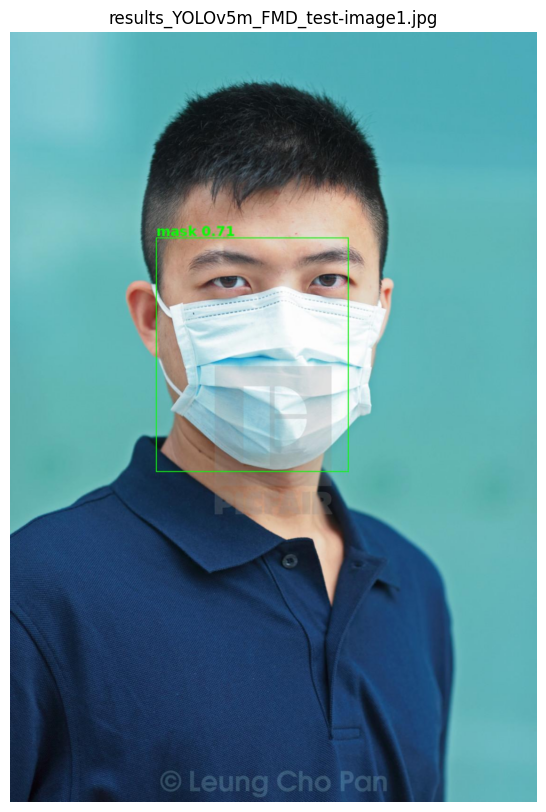

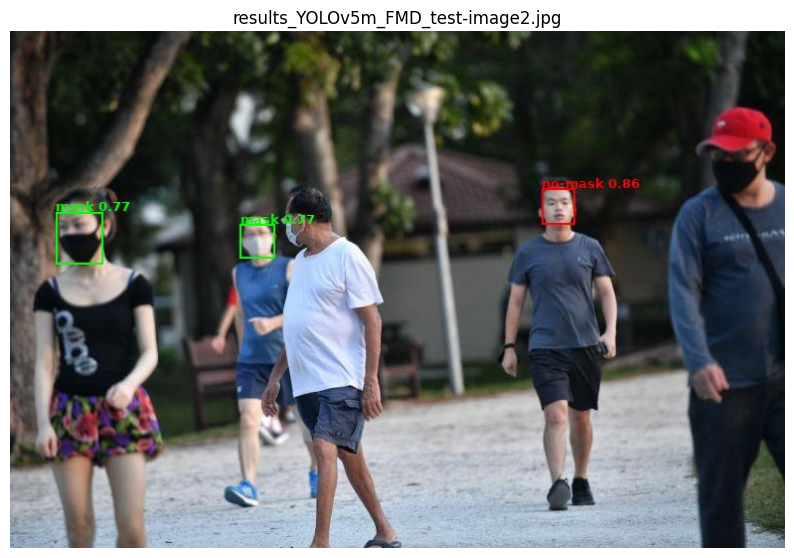

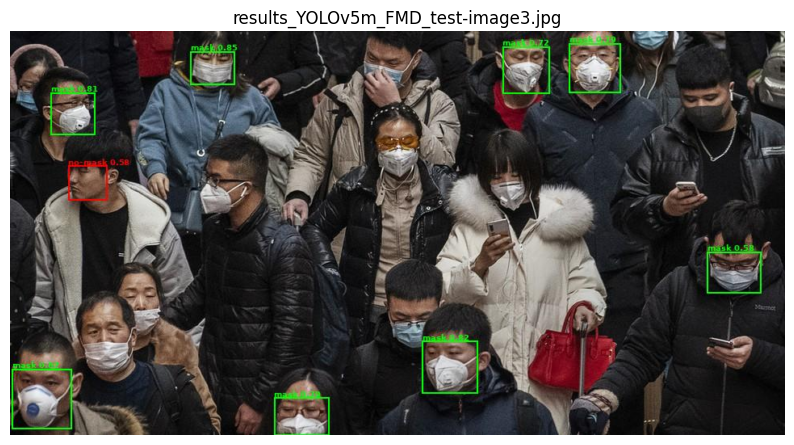

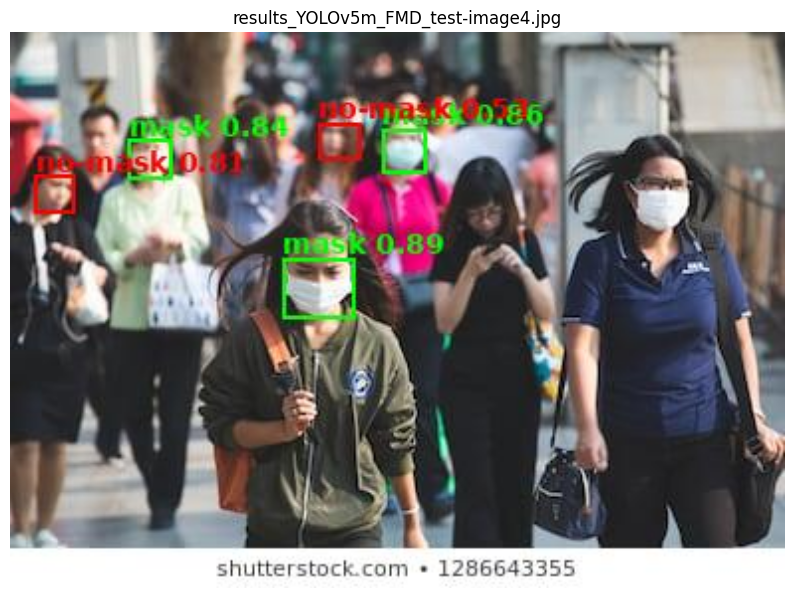

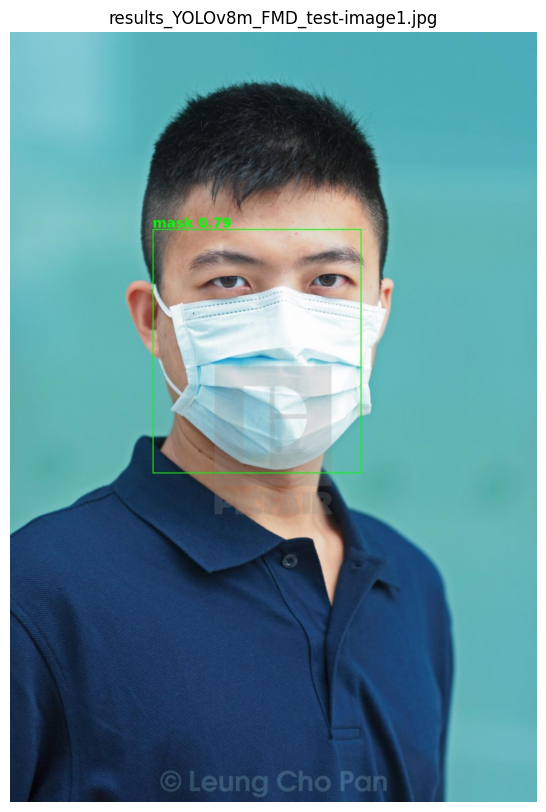

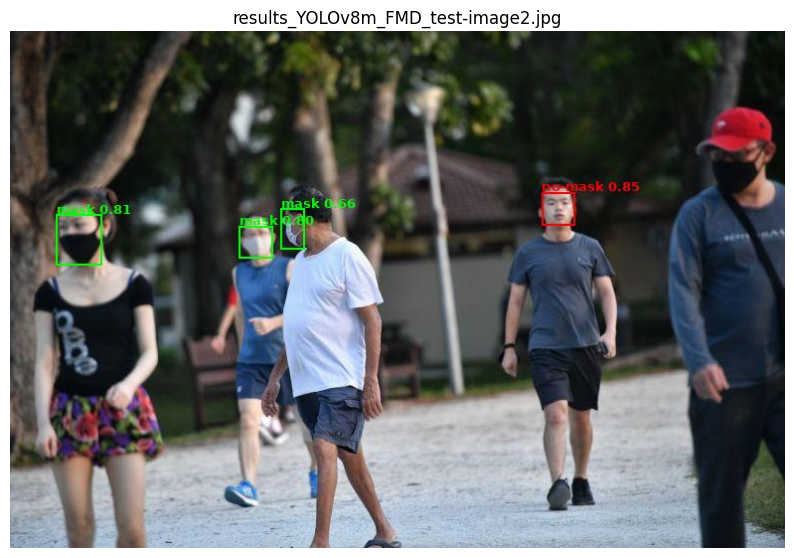

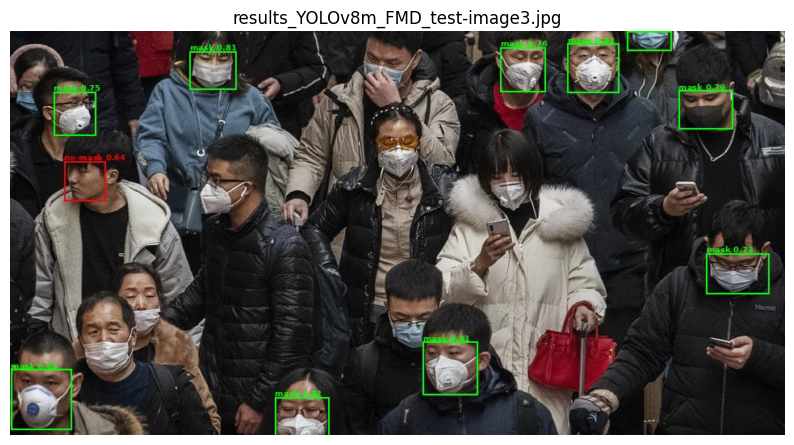

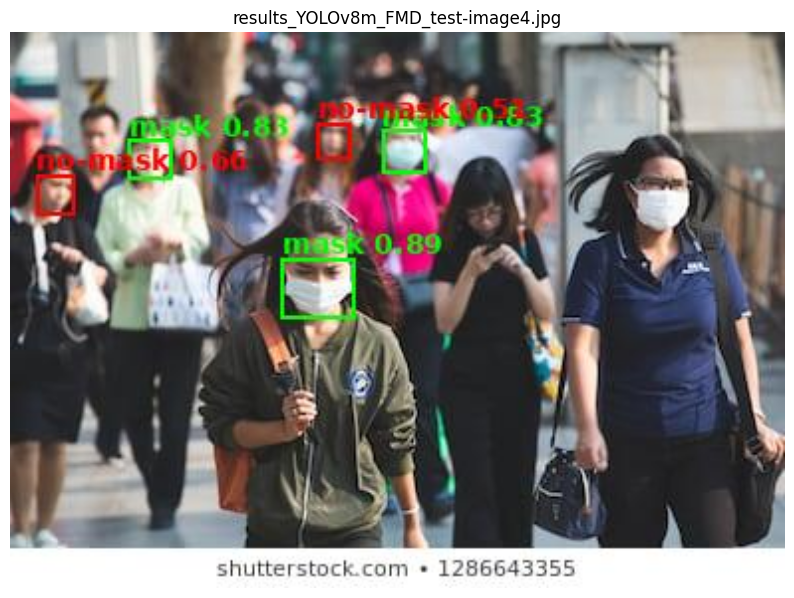

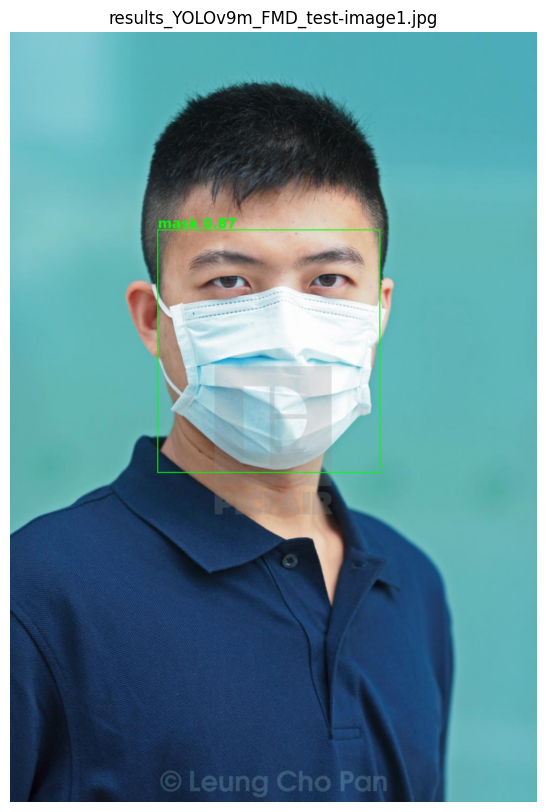

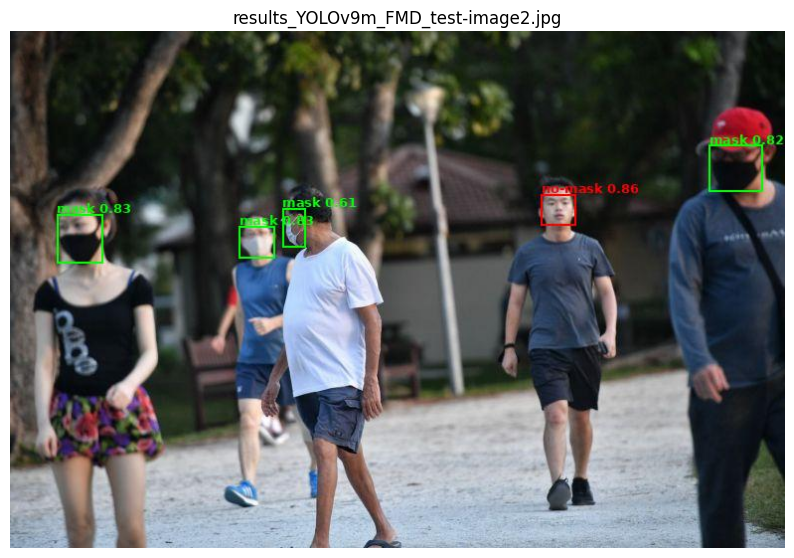

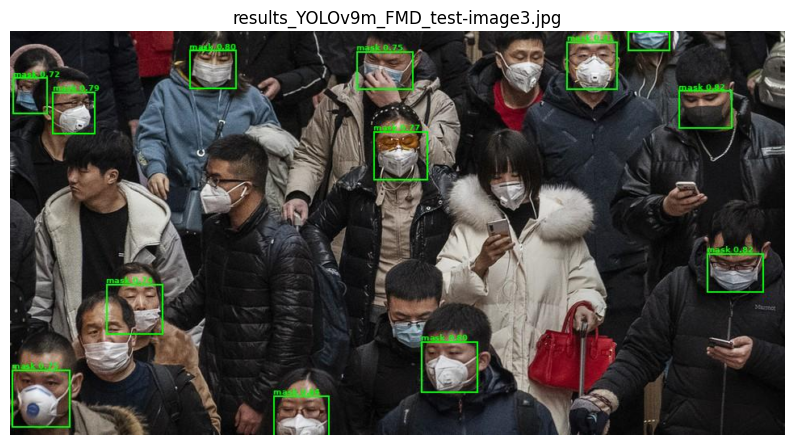

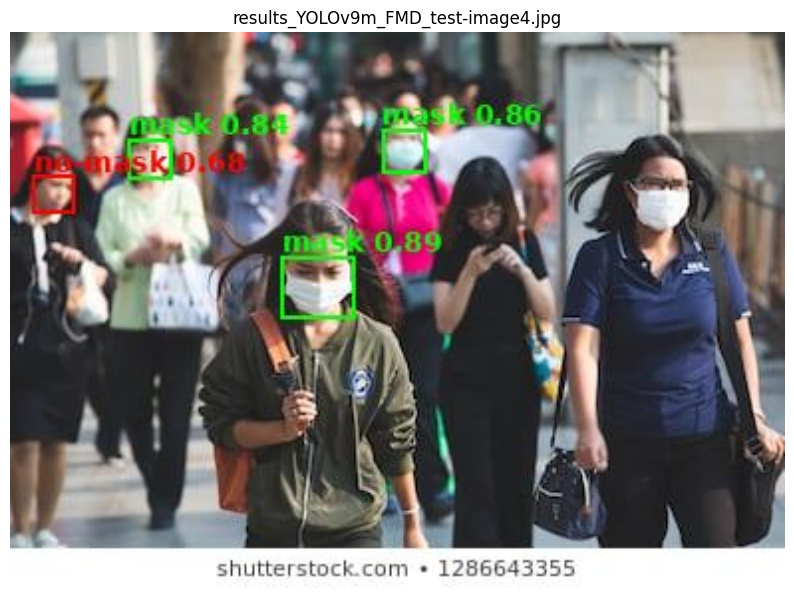

In [30]:
list_results = load_images(path_results_dir)

for result in list_results:
    path = os.path.join(path_results_dir, result)
    image = cv2.imread(path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 10))
    plt.imshow(image_rgb)
    plt.title(result)
    plt.axis('off')
    plt.show()

Note: for each image a *.csv file is created from the data `x1, y1, x2, y2, confidence, class_id`

## References and other materials

[ONNX Export for YOLOv8 Models](https://docs.ultralytics.com/integrations/onnx/)

[Model Export with Ultralytics YOLO](https://docs.ultralytics.com/modes/export/#introduction)

[Model Training with Ultralytics YOLO](https://docs.ultralytics.com/modes/train/)

[Deep learning: How OpenCV’s blobFromImage works](https://pyimagesearch.com/2017/11/06/deep-learning-opencvs-blobfromimage-works/)

[OpenCV - Deep Neural Network module](https://docs.opencv.org/3.4/d6/d0f/group__dnn.html)

[How OpenCV’s blobFromImage works?](https://www.geeksforgeeks.org/how-opencvs-blobfromimage-works/)